In [39]:
import numpy as np
import pandas as pd
import sys,os
import glob
import scipy.optimize as spo
sys.path.append(sys.path[0] + '/..')

import matplotlib.pyplot as plt
import matplotlib

from imp import reload
import platereaderclass as prc; reload(prc);
import plates_EstimateMSP as eMSP; reload(eMSP);


In [40]:
basedir = '/home/lukas/projects/antibiotics/experiments/200129_AllData/'

design_assignment_andy = {  'andy_WT.xlsx':         [0, 1, 2], 
                            'andy_TEM1.xlsx':       [0, 0, 1, 1, 2, 2], 
                            'andy_E104KG238S.xlsx': [0, 0, 1, 1, 2, 2],
                            'andy_G238S.xlsx':      [0, 0, 1, 1, 2, 2],
                            'andy_Triple.xlsx':     [0, 1, 2]}

design_assignment_philip = {'philip_G238S.xlsx':    [0, 0, 0, 0, 0, 0, 0, 0],
                            'philip_Triple.xlsx':   [0, 0, 1, 1, 1, 1, 0, 0]}


def make_argparse_options(filename,design_assignment):
    return ['-q','-i',basedir + filename.split('_')[0] + '/data/' + filename,'-M','NfuncB','BfuncN', '-D'] + [str(i) for i in design_assignment]

def AddDF(df1 = None,df2 = None):
    if df1 is None:    return df2
    elif df2 is None:  return df1
    else:              return pd.concat([df1,df2],ignore_index = True)

def split_allele_name_andy(df):
    def split_iptg(allele):
        if allele[-4:].upper() == 'IPTG': return [allele[:-5],allele[-5:]]
        else:                             return [allele,'+IPTG']
    data = [x.strip('andy') for x in df['Title'].values]
    data = np.array([['andy',split_iptg(x.split('_')[0])[0],split_iptg(x.split('_')[0])[1],x.split('_')[1]] for x in data])
    df['exp'] = 'andy'
    df['Allele'] = data[:,1]
    df['ExprLevel'] = data[:,2]
    df['Repetition'] = data[:,3]
    return df

def split_allele_name_philip(df):
    data = np.array([x.split('_') for x in df['Title'].values])
    df['exp'] = 'philip'
    df['Allele'] = data[:,0]
    df['ExprLevel'] = data[:,1]
    df['Repetition'] = data[:,2]
    return df



In [41]:
data = prc.PlateReaderData(infiles = ['/home/lukas/projects/antibiotics/experiments/200129_AllData/andy/data/andy_WT.xlsx'], DesignAssignment=[0,1,2], verbose = True)

#                                     '/home/lukas/projects/antibiotics/experiments/200129_AllData/andy/data

data

/home/lukas/projects/antibiotics/experiments/200129_AllData/andy/data/andy_WT.xlsx
Plate design BFP RepA True
Plate design BFP RepB True
Plate design BFP repC True
andyWT_A False
andyWT_B False
andyWT_C False
Plate design BFP RepA True
Plate design BFP RepB True
Plate design BFP repC True
andyWT_A False
andyWT_B False
andyWT_C False


In [33]:
results_andy = None
for datafile in design_assignment_andy.keys():
    p = make_argparse_options(datafile,design_assignment_andy[datafile])
    print(p)
    curres = eMSP.EstimateMSP(params = p)
    results_andy = AddDF(results_andy,curres)

results_philip = None
for datafile in design_assignment_philip.keys():
    curres = eMSP.EstimateMSP(params = make_argparse_options(datafile,design_assignment_philip[datafile]))
    results_philip = AddDF(results_philip,curres)
    
results = AddDF(split_allele_name_andy(results_andy),split_allele_name_philip(results_philip))

results

['-q', '-i', '/home/lukas/projects/antibiotics/experiments/200129_AllData/andy/data/andy_WT.xlsx', '-M', 'NfuncB', 'BfuncN', '-D', '0', '1', '2']


TypeError: 'NoneType' object is not callable

In [21]:
colors1 = {'andy':'TAB:BLUE','philip':'TAB:ORANGE'}
colors2 = {'andy':'TAB:GREEN','philip':'TAB:RED'}
alleles = {'WT':'+','TEM1': 3,'G238S': 4,'E104KG238S': 5,'Triple': 6}
exprlevel = {'-IPTG':1,'+IPTG':3,'None':0,'Low':1,'Med':2,'High':3}


def polygon(corners = 4, inner = False, cross = False, linedist = .45):
    if corners == '+':
        vertices           = [[0,1],[0,-1],[-1,0],[1,0]]
        codes              = [matplotlib.path.Path.MOVETO, matplotlib.path.Path.LINETO, matplotlib.path.Path.MOVETO, matplotlib.path.Path.LINETO]
    else:
        vertices           = [[np.sin(2*np.pi*i/corners), np.cos(2*np.pi*i/corners)] for i in range(corners + 1)]
        codes              = [matplotlib.path.Path.MOVETO] + [matplotlib.path.Path.LINETO for i in range(corners-1)] + [matplotlib.path.Path.CLOSEPOLY]
        if inner:
            scalereduction = (np.cos(np.pi/corners) - linedist)/np.cos(np.pi/corners)
            vertices       = np.concatenate([vertices,np.multiply(scalereduction, vertices)])
            codes          = np.concatenate([codes,codes])
        if cross:
            vertices       = np.concatenate([vertices, [[0,1],[0,-1],[-1,0],[1,0]]])
            codes          = np.concatenate([codes, [matplotlib.path.Path.MOVETO, matplotlib.path.Path.LINETO, matplotlib.path.Path.MOVETO, matplotlib.path.Path.LINETO]])
    return matplotlib.path.Path(vertices, codes)


def plotoptions(datarow, errorbars = False):        
    ret = {}
    if not errorbars:
        ret['edgecolor'] = colors1[datarow['exp']]
        ret['marker']    = polygon(corners = alleles[datarow['Allele']], inner = (exprlevel[datarow['ExprLevel']] == 2), cross = (datarow['ExprLevel']=='None'))
        ret['facecolor'] = (colors1[datarow['exp']] if exprlevel[datarow['ExprLevel']] == 3 else 'None')
        ret['alpha']     = 1
        ret['s']         = 200
    else:
        ret['alpha']     = 0.2
        ret['c']         = colors1[datarow['exp']]
    ret['lw']        = 2
    return ret


{'andy': array([3.76573907e-02, 2.36126787e+06]), 'philip': array([4.55879964e-02, 1.17674529e+06])}
{'andy': array([[ 1.09402343e-04, -4.74511362e+03],
       [-4.74511362e+03,  2.62822394e+11]]), 'philip': array([[ 2.78782469e-03, -3.97594333e+04],
       [-3.97594333e+04,  6.62130771e+11]])}


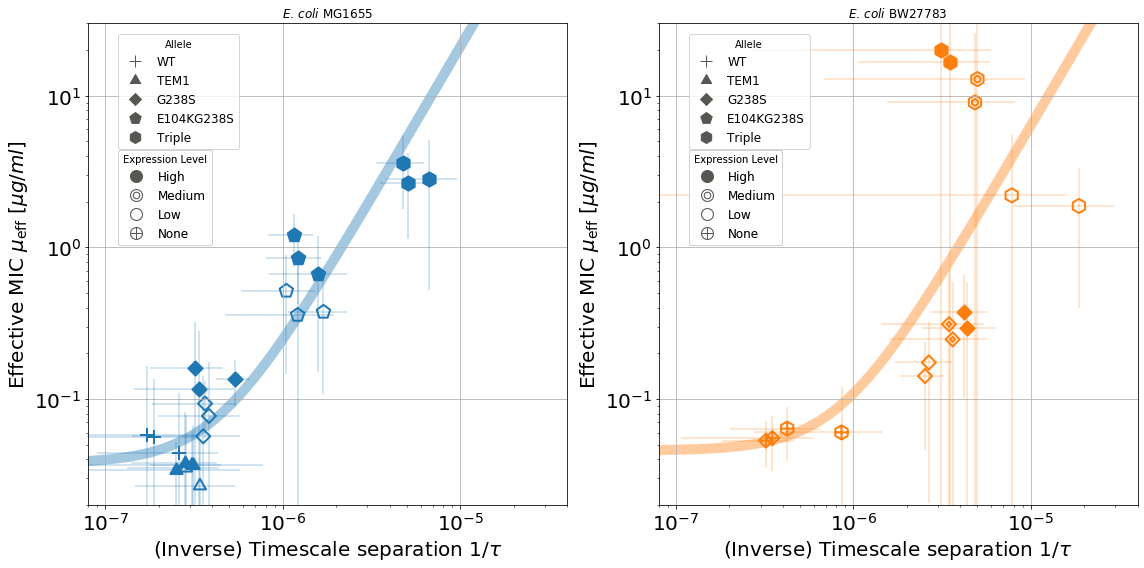

In [22]:
andy_label   = r'$E.\,coli~\mathrm{MG1655}$'
philip_label = r'$E.\,coli~\mathrm{BW27783}$'

def PlotTauMIC(filename = 'tau_smic.pdf', exclude_experiment_keys = [], separate_strains = False, show_errors = False):
    
    
    def logmueff(tau,m0,phi):
        return np.log((1+phi**2/tau**2)*m0)

    fitvalues = {}
    cov       = {}
    for exp in ['andy','philip']:
        tau   = 1/results[(results['exp'] == exp) & ~results['Title'].isin(exclude_experiment_keys)]['NB_tau'].values
        mueff = results[(results['exp'] == exp) & ~results['Title'].isin(exclude_experiment_keys)]['NB_sMIC'].values

        m0_estimate = np.min(mueff)
        phi_estimate = np.sqrt(np.exp(2*np.mean(np.log(tau)) + np.mean(np.log(mueff)))/m0_estimate)

        fitvalues[exp], cov[exp] = spo.curve_fit(logmueff,tau, np.log(mueff),p0 = [m0_estimate,phi_estimate])

    print(fitvalues)
    print(cov)    

    if not separate_strains:
        fig,ax           = plt.subplots(1,1,figsize = (8,8))
        axplot = {'andy':ax,'philip':ax}
    else:
        fig,ax = plt.subplots(1,2,figsize = (16,8))
        axplot = {'andy':ax[0], 'philip':ax[1]}
        
    for index,experiment in results.iterrows():
        if not experiment['Title'] in exclude_experiment_keys:
            if show_errors:
                axplot[experiment['exp']].errorbar(experiment['NB_tau'],experiment['NB_sMIC'], yerr = experiment['NB_sMIC_stddev'], xerr = experiment['NB_tau_stddev'],  **plotoptions(experiment, errorbars=True))
            axplot[experiment['exp']].scatter(experiment['NB_tau'],experiment['NB_sMIC'], **plotoptions(experiment))

    axplot['andy'].set_yscale('log')
    axplot['andy'].set_xscale('log')
    axplot['andy'].set_xlim([8e-8,4e-5])
    axplot['andy'].set_ylim([2e-2,3e1])
    axplot['andy'].set_xlabel(r'(Inverse) Timescale separation $1/\tau$', fontsize = 20)
    axplot['andy'].set_ylabel(r'Effective MIC $\mu_\mathrm{{eff}}$ $[\mu g/ml]$', fontsize = 20)
    axplot['andy'].tick_params(labelsize=20)

    if separate_strains:
        axplot['philip'].set_yscale('log')
        axplot['philip'].set_xscale('log')
        axplot['philip'].set_xlim([8e-8,4e-5])
        axplot['philip'].set_ylim([2e-2,3e1])
        axplot['philip'].set_xlabel(r'(Inverse) Timescale separation $1/\tau$', fontsize = 20)
        axplot['philip'].set_ylabel(r'Effective MIC $\mu_\mathrm{{eff}}$ $[\mu g/ml]$', fontsize = 20)
        axplot['philip'].tick_params(labelsize=20)

    xx = np.exp(np.linspace(np.log(axplot['andy'].get_xlim()[0]), np.log(axplot['andy'].get_xlim()[1]), num = 200))
    axplot['andy'].plot(xx,np.exp(logmueff(1/xx,fitvalues['andy'][0],   fitvalues['andy'][1])),   c = colors1['andy'],   lw = 10, alpha = .4, zorder = -2)
    axplot['philip'].plot(xx,np.exp(logmueff(1/xx,fitvalues['philip'][0], fitvalues['philip'][1])), c = colors1['philip'], lw = 10, alpha = .4, zorder = -2)

    legendcolor = '#555753'
    if not separate_strains:
        allele_legend_markers = [matplotlib.lines.Line2D([0],[0], marker = polygon(corners = marker), color = legendcolor, markersize = 12, linestyle='None') for label,marker in alleles.items()]
        allele_legend_labels  = [label for label,marker in alleles.items()]
        allele_legend = plt.legend(allele_legend_markers, allele_legend_labels, title = 'Allele',bbox_to_anchor=(0.05,0.99), loc = 'upper left', fontsize = 12)
        axplot['andy'].add_artist(allele_legend)

        exprlvl_legend_markers = [  matplotlib.lines.Line2D([0],[0], marker = polygon(20, False),       markerfacecolor = legendcolor, markeredgecolor = legendcolor, linestyle = 'None', markersize = 12),
                                    matplotlib.lines.Line2D([0],[0], marker = polygon(20, True),        markerfacecolor = 'None',      markeredgecolor = legendcolor, linestyle = 'None', markersize = 12),
                                    matplotlib.lines.Line2D([0],[0], marker = polygon(20, False),       markerfacecolor = 'None',      markeredgecolor = legendcolor, linestyle = 'None', markersize = 12),
                                    matplotlib.lines.Line2D([0],[0], marker = polygon(20, False, True), markerfacecolor = 'None',      markeredgecolor = legendcolor, linestyle = 'None', markersize = 12)]
        exprlvl_legend_labels  = ['High', 'Medium', 'Low', 'None']

        exprlvl_legend = plt.legend(exprlvl_legend_markers, exprlvl_legend_labels, title = 'Expression Level', bbox_to_anchor = (.05,0.75), loc = 'upper left', fontsize = 12)
        axplot['andy'].add_artist(exprlvl_legend)

        strain_legend_markers = [   matplotlib.lines.Line2D([0],[0], marker = polygon(6,False), markerfacecolor = colors1['andy'],   markeredgecolor = colors1['andy'],   linestyle = 'None', markersize = 12),
                                    matplotlib.lines.Line2D([0],[0], marker = polygon(6,False), markerfacecolor = colors1['philip'], markeredgecolor = colors1['philip'], linestyle = 'None', markersize = 12)]
        strain_legend_labels  = [andy_label, philip_label]
        axplot['andy'].legend(strain_legend_markers, strain_legend_labels, title = 'Strain', bbox_to_anchor = (.05, 0.54), loc = 'upper left', fontsize = 12)
        axplot['andy'].grid()
    
    else:
        allele_legend_markers1 = [matplotlib.lines.Line2D([0],[0], marker = polygon(corners = marker), color = legendcolor, markersize = 12, linestyle='None') for label,marker in alleles.items()]
        allele_legend_labels1  = [label for label,marker in alleles.items()]
        allele_legend1 = axplot['andy'].legend(allele_legend_markers1, allele_legend_labels1, title = 'Allele',bbox_to_anchor=(0.05,0.99), loc = 'upper left', fontsize = 12)
        axplot['andy'].add_artist(allele_legend1)

        allele_legend_markers2 = [matplotlib.lines.Line2D([0],[0], marker = polygon(corners = marker), color = legendcolor, markersize = 12, linestyle='None') for label,marker in alleles.items()]
        allele_legend_labels2  = [label for label,marker in alleles.items()]
        allele_legend2 = axplot['philip'].legend(allele_legend_markers2, allele_legend_labels2, title = 'Allele',bbox_to_anchor=(0.05,0.99), loc = 'upper left', fontsize = 12)
        axplot['philip'].add_artist(allele_legend2)

        exprlvl_legend_markers1 = [  matplotlib.lines.Line2D([0],[0], marker = polygon(20, False),       markerfacecolor = legendcolor, markeredgecolor = legendcolor, linestyle = 'None', markersize = 12),
                                     matplotlib.lines.Line2D([0],[0], marker = polygon(20, True),        markerfacecolor = 'None',      markeredgecolor = legendcolor, linestyle = 'None', markersize = 12),
                                     matplotlib.lines.Line2D([0],[0], marker = polygon(20, False),       markerfacecolor = 'None',      markeredgecolor = legendcolor, linestyle = 'None', markersize = 12),
                                     matplotlib.lines.Line2D([0],[0], marker = polygon(20, False, True), markerfacecolor = 'None',      markeredgecolor = legendcolor, linestyle = 'None', markersize = 12)]
        exprlvl_legend_labels1  = ['High', 'Medium', 'Low', 'None']
        exprlvl_legend1 = axplot['andy'].legend(exprlvl_legend_markers1, exprlvl_legend_labels1, title = 'Expression Level', bbox_to_anchor = (.05,0.75), loc = 'upper left', fontsize = 12)
        axplot['andy'].add_artist(exprlvl_legend1)

        exprlvl_legend_markers2 = [  matplotlib.lines.Line2D([0],[0], marker = polygon(20, False),       markerfacecolor = legendcolor, markeredgecolor = legendcolor, linestyle = 'None', markersize = 12),
                                     matplotlib.lines.Line2D([0],[0], marker = polygon(20, True),        markerfacecolor = 'None',      markeredgecolor = legendcolor, linestyle = 'None', markersize = 12),
                                     matplotlib.lines.Line2D([0],[0], marker = polygon(20, False),       markerfacecolor = 'None',      markeredgecolor = legendcolor, linestyle = 'None', markersize = 12),
                                     matplotlib.lines.Line2D([0],[0], marker = polygon(20, False, True), markerfacecolor = 'None',      markeredgecolor = legendcolor, linestyle = 'None', markersize = 12)]
        exprlvl_legend_labels2  = ['High', 'Medium', 'Low', 'None']
        exprlvl_legend2 = axplot['philip'].legend(exprlvl_legend_markers2, exprlvl_legend_labels2, title = 'Expression Level', bbox_to_anchor = (.05,0.75), loc = 'upper left', fontsize = 12)
        axplot['philip'].add_artist(exprlvl_legend2)
        
        axplot['andy'].set_title(andy_label)
        axplot['philip'].set_title(philip_label)
        
        axplot['andy'].grid()
        axplot['philip'].grid()
        
    fig.tight_layout()
    fig.savefig(filename)

    
exclude = {'None':[],'Triple':['Triple_High_1', 'Triple_High_2', 'Triple_Med_1', 'Triple_Med_2','Triple_Low_1','Triple_Low_2','Triple_None_1','Triple_None_2'], 'TripleHigh':['Triple_High_1', 'Triple_High_2', 'Triple_Med_1', 'Triple_Med_2']}
separate_strains = {'sep':True, 'both':False}
errorbars = {'Errorbars':True, 'NoErrorbars':False}

#for ename,e in exclude.items():
#    for sname, s in separate_strains.items():
#        for ebname, eb in errorbars.items():
#            PlotTauMIC(filename = 'tau_smic_{}_{}_{}.pdf'.format(ename,sname,ebname), exclude_experiment_keys = e, separate_strains = s, show_errors = eb)

PlotTauMIC(filename = 'tmp.pdf', exclude_experiment_keys=[], separate_strains=True, show_errors=True)


In [12]:
def grid2design(gridcoordinates, plate_size, griddesign = (12.,8.)):
    if isinstance(gridcoordinates[0],(list,tuple,np.ndarray)):
        return np.array([grid2design(gc,plate_size, griddesign) for gc in gridcoordinates])
    else:
        return np.array([ 
                plate_size['Bmin'] * np.power(plate_size['Bmax']/plate_size['Bmin'],gc[0]/(griddesign[0]-1.)),
                plate_size['Nmin'] * np.power(plate_size['Nmax']/plate_size['Nmin'],1. - gc[1]/(griddesign[1]-1.))
            ])


def design2grid(designcoordinates, plate_size, griddesign = (12.,8.)):
    return np.array([[
        (griddesign[0]-1) * (np.log(dc[0]/plate_size['Bmin']))/np.log(plate_size['Bmax']/plate_size['Bmin']),
        (griddesign[1]-1) * (1 - (np.log(dc[1]/plate_size['Nmin']))/np.log(plate_size['Nmax']/plate_size['Nmin']))
    ] for dc in designcoordinates])
    

def adjust_ax(ax, plate_size, fc = '#d3d7cf'):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    xticks = [1e-2,1e-1,1e0,1e1]
    yticks = [1e3,1e5,1e7]
    
    xtickpos = design2grid(np.array([xticks,np.ones_like(xticks)]).T, plate_size = plate_size)[:,0]
    ytickpos = design2grid(np.array([np.ones_like(yticks),yticks]).T, plate_size = plate_size)[:,1]

    ax.set_xticks(xtickpos)
    ax.set_xticklabels([r'$10^{{{:d}}}$'.format(int(np.log10(x))) for x in xticks], fontsize = 20)
    ax.set_yticks(ytickpos)
    ax.set_yticklabels([r'$10^{{{:d}}}$'.format(int(np.log10(y))) for y in yticks], fontsize = 20)

    ax.set_xlim([-.6,11.6])
    ax.set_ylim([7.6,-.6])
    
    background = matplotlib.patches.Rectangle([ax.get_xlim()[0],ax.get_ylim()[0]],np.diff(ax.get_xlim()),np.diff(ax.get_ylim()), fc = fc, zorder = -1)
    ax.add_patch(background)

    ax.set_xlabel(r'Initial Antibiotic Concentration $B_0$ $[\mu g/ml]$', fontsize = 20)
    ax.set_ylabel(r'Inoculum size $N_0$', fontsize = 20)
    
    
def patch_color(value, color1 = [ 65,101,164], color2 = [255,255,255], hexoutput = True):
    value = np.max([0,np.min([1,value])])
    if hexoutput:
        return '#{:02X}{:02X}{:02X}'.format(int(color1[0] * value + color2[0] * (1-value)),int(color1[1] * value + color2[1] * (1-value)),int(color1[2] * value + color2[2] * (1-value)))
    else:
        return [int(color1[0] * value + color2[0] * (1-value)),int(color1[1] * value + color2[1] * (1-value)),int(color1[2] * value + color2[2] * (1-value))]

def plot_well(ax, pos, value, thres, plate_pos, plate_data_shape, radius = 0.4):
    border_color = '#2e3436'
    if value <= thres:
        border_color = '#a40000'
    circle = matplotlib.patches.Circle(pos,radius,facecolor = patch_color(value), edgecolor = border_color, linewidth = 3)
    ax.add_patch(circle)

    
def rescale(platedata, threshold):
    return (platedata - np.min(platedata))/(np.max(platedata) - np.min(platedata)),(threshold - np.min(platedata))/(np.max(platedata)-np.min(platedata))


def BfuncN(N, tau, smic): return smic*np.exp((N-1)/tau)
def NfuncB(B, tau, smic): return 1 + tau * np.log(B/smic)



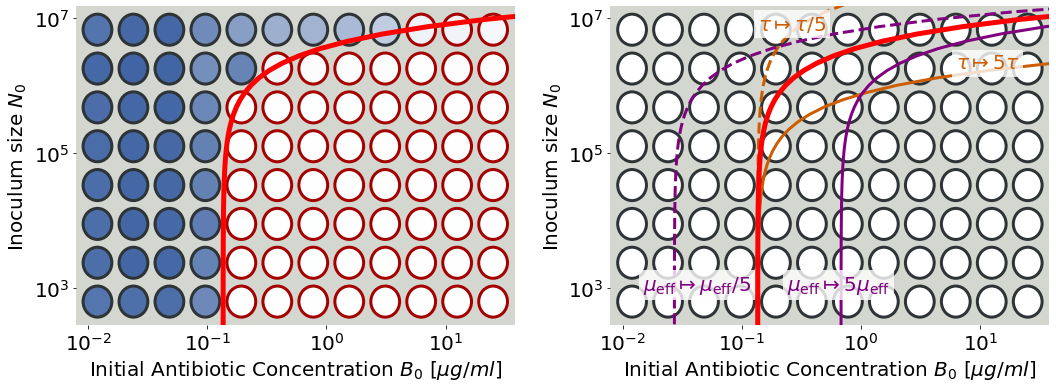

In [13]:
filename             = basedir + 'andy/data/andy_G238S.xlsx'
experiment_index     = 1
experiment_data      = prc.PlateReaderData(infiles = [filename])
platedata, threshold = rescale(experiment_data[experiment_index].T, experiment_data.EstimateGrowthThreshold())
design               = experiment_data.get_design(0)
plate_size           = {'Nmin':np.min(design[1]), 'Nmax':np.max(design[1]), 'Bmin':np.min(design[0]), 'Bmax':np.max(design[0])}
estimates            = results[results['Filename'] == filename].iloc[experiment_index,:]
fig, ax              = plt.subplots(1,2,figsize = (15,5.5))

color_change_tau = '#ce5c00'
color_change_mu  = 'purple'

for x in range(platedata.shape[0]):
    for y in range(platedata.shape[1]):
        plot_well(ax[0], [x,y], platedata[x,y], threshold, plate_size, platedata.shape)
        plot_well(ax[1], [x,y],              0,        -1, plate_size, platedata.shape)

nlist             = np.exp(np.linspace(np.log(1e2),np.log(2e7),num=50))
mspcurve          = design2grid(np.array([BfuncN(nlist,1/estimates['NB_tau'],estimates['NB_sMIC']),nlist]).T, plate_size)

scalefactor       = 5.
mspcurve_tau_inc  = design2grid(np.array([BfuncN(nlist,(1./scalefactor)/estimates['NB_tau'],estimates['NB_sMIC']),nlist]).T, plate_size)
mspcurve_tau_dec  = design2grid(np.array([BfuncN(nlist,scalefactor/estimates['NB_tau'],estimates['NB_sMIC']),nlist]).T, plate_size)
mspcurve_smic_inc = design2grid(np.array([BfuncN(nlist,1/estimates['NB_tau'],scalefactor*estimates['NB_sMIC']),nlist]).T, plate_size)
mspcurve_smic_dec = design2grid(np.array([BfuncN(nlist,1/estimates['NB_tau'],(1./scalefactor)*estimates['NB_sMIC']),nlist]).T, plate_size)

ax[0].plot(mspcurve[:,0],mspcurve[:,1], lw = 5, c = 'red', zorder = 100)
ax[1].plot(mspcurve[:,0],mspcurve[:,1], lw = 5, c = 'red', zorder = 100)
ax[1].plot(mspcurve_tau_inc[:,0],  mspcurve_tau_inc[:,1],  lw = 3, c = color_change_tau)
ax[1].plot(mspcurve_tau_dec[:,0],  mspcurve_tau_dec[:,1],  lw = 3, c = color_change_tau, linestyle = '--')
ax[1].plot(mspcurve_smic_inc[:,0], mspcurve_smic_inc[:,1], lw = 3, c = color_change_mu)
ax[1].plot(mspcurve_smic_dec[:,0], mspcurve_smic_dec[:,1], lw = 3, c = color_change_mu, linestyle = '--')

ax[1].annotate(r'$\tau\mapsto{}\tau$'.format(int(scalefactor)),                              [9.0,1.0], c = color_change_tau, fontsize = 20, weight = 'bold').set_bbox({'facecolor': 'white', 'alpha': .8,'edgecolor': None, 'linewidth': 0})
ax[1].annotate(r'$\tau\mapsto\tau/{}$'.format(int(scalefactor)),                             [3.5,0.0], c = color_change_tau, fontsize = 20, weight = 'bold').set_bbox({'facecolor': 'white', 'alpha': .8,'edgecolor': None, 'linewidth': 0})
ax[1].annotate(r'$\mu_\mathrm{{eff}}\mapsto{}\mu_\mathrm{{eff}}$'.format(int(scalefactor)),  [4.3,6.7], c = color_change_mu,  fontsize = 20, weight = 'bold').set_bbox({'facecolor': 'white', 'alpha': .8,'edgecolor': None, 'linewidth': 0})
ax[1].annotate(r'$\mu_\mathrm{{eff}}\mapsto\mu_\mathrm{{eff}}/{}$'.format(int(scalefactor)), [0.3,6.7], c = color_change_mu,  fontsize = 20, weight = 'bold').set_bbox({'facecolor': 'white', 'alpha': .8,'edgecolor': None, 'linewidth': 0})

adjust_ax(ax[0], plate_size)
adjust_ax(ax[1], plate_size)
fig.tight_layout()

fig.savefig('platedata.pdf')

In [14]:
def adjust_ax_fig2_N(ax):
    ax.set_yscale('log')
    ax.set_ylim([1e0,2e7])
    ax.set_yticks([1e1,1e3,1e5,1e7])
    ax.set_xticks([0,6,12,18,24])
    ax.set_xlim([0,24])
    ax.set_xlabel(r'Time $t$ $[h]$', fontsize = 20)
    ax.set_ylabel(r'Population Size $N$', fontsize = 20)
    ax.tick_params(labelsize = 20)

def adjust_ax_fig2_B(ax):
    #ax.set_yscale('log')
    ax.set_ylim([0,3])
    ax.set_yticks([0,1,2,3])
    ax.set_xticks([0,6,12,18,24])
    ax.set_xlim([0,24])
    ax.set_xlabel(r'Time $t$ $[h]$', fontsize = 20)
    ax.set_ylabel(r'Antibiotic Concentration $B$', fontsize = 20)
    ax.tick_params(labelsize = 20)


def PlotFadingTrajectory(ax, x, y, threshold1 = 2e4, threshold2 = 1e6, color1 = [0,255,255], color2 = [255,255,255], label = None, plot_params = {}):
    data            = pd.DataFrame({'x':x,'y':y})
    data_c1         = data[data['y'] <= threshold1]
    data_transition = data[(threshold1 < data['y']) & (data['y'] <= threshold2)]
    data_c2         = data[threshold2 < data['y']]
    
    if len(data_c1) > 0 and len(data_transition) > 0:
        data_transition = pd.concat([data_c1.tail(1), data_transition])
    if len(data_c2) > 0 and len(data_transition) > 0:
        data_transition = pd.concat([data_transition, data_c2.head(1)])
    
    ax.plot(data_c1['x'], data_c1['y'], c = patch_color(1, color1 = color1, color2 = color2), **plot_params, label = label)
    
    if len(data_transition) > 1:
        for i in range(len(data_transition)-1):
            t = 1. - 1. * i/len(data_transition)
            ax.plot(data_transition['x'].values[i:i+2], data_transition['y'].values[i:i+2], c = patch_color(t, color1 = color1, color2 = color2), **plot_params)

    if len(data_c2) > 0:
        ax.plot(data_c2['x'],data_c2['y'], c = patch_color(0, color1 = color1, color2 = color2), **plot_params)
    
    
    
class EnzymePopulationDynamics(object):
    def __init__(self, **kwargs):
        self.__initial_popsize = kwargs.get('popsize',1e4)
        self.__initial_ABconc  = kwargs.get('ABConc',1.5)
        self.__initial_enzyme  = kwargs.get('EnzymeConc',0)
        self.__epsilon         = kwargs.get('epsilon',1e-3)
        self.__rho             = kwargs.get('rho',1e-3)
        
        self.__growthrate      = kwargs.get('growthrate',1.)
        self.__kappa           = kwargs.get('kappa',2.)
        self.__gamma           = kwargs.get('gamma',2.)
        
        self.integration_step  = kwargs.get('integrationstep',1e-2)
        self.output_step       = kwargs.get('outputstep',10)
        self.maxtime           = kwargs.get('maxtime',24)
        
        self.x                 = np.array([[self.__initial_popsize, self.__initial_enzyme, self.__initial_ABconc]])
        self.time              = 0
  

    def RungeKutta4(self, func, xx ,time):
        # 4th order Runge-Kutta integration scheme
        k1 = self.integration_step * func(xx,            time)
        k2 = self.integration_step * func(xx + 0.5 * k1, time + 0.5 * self.integration_step)
        k3 = self.integration_step * func(xx + 0.5 * k2, time + 0.5 * self.integration_step)
        k4 = self.integration_step * func(xx + k3,       time +       self.integration_step)
        return xx + (k1 + 2. * k2 + 2. * k3 + k4)/6.
    
        
    def dynamics(self, x, time):
        bk = np.power(x[2], self.__kappa)
        return np.array([
            self.__growthrate * (1 - bk)/(1 + bk/self.__gamma) * x[0],
            self.__rho * x[0],
            np.max([-self.__epsilon * x[1] * x[2],-x[2]])
        ])
    
    def run(self):
        i = 0
        xlast = self.x[-1]
        while self.time <= self.maxtime:
            xnew = self.RungeKutta4(self.dynamics, xlast, self.time)
            if xnew[0] < 1: xnew[0] = 0
            if xnew[2] < 0: xnew[2] = 0
            xlast = xnew
            i += 1
            if i % self.output_step == 0:
                self.x = np.concatenate([self.x,[xnew]], axis = 0)
            self.time += self.integration_step
        
        return pd.DataFrame({'time':np.arange(len(self.x[:,0])) * self.integration_step * self.output_step, 'N':self.x[:,0], 'E':self.x[:,1], 'B':self.x[:,2]})
    

In [15]:
default_params = {'epsilon':1e-2, 'rho':1e-2}

trajectories0010 = {}
trajectories0100 = {}
trajectories1000 = {}
for abconc in np.linspace(0,3, num = 16):
    b0 = '{:.2f}'.format(abconc)
    print(b0)
    trajectories0010[b0] = EnzymePopulationDynamics(popsize = 1e1, ABConc = abconc, **default_params).run()
    trajectories0100[b0] = EnzymePopulationDynamics(popsize = 1e2, ABConc = abconc, **default_params).run()
    trajectories1000[b0] = EnzymePopulationDynamics(popsize = 1e3, ABConc = abconc, **default_params).run()


0.00
0.20
0.40
0.60
0.80
1.00
1.20
1.40
1.60
1.80
2.00
2.20
2.40
2.60
2.80
3.00


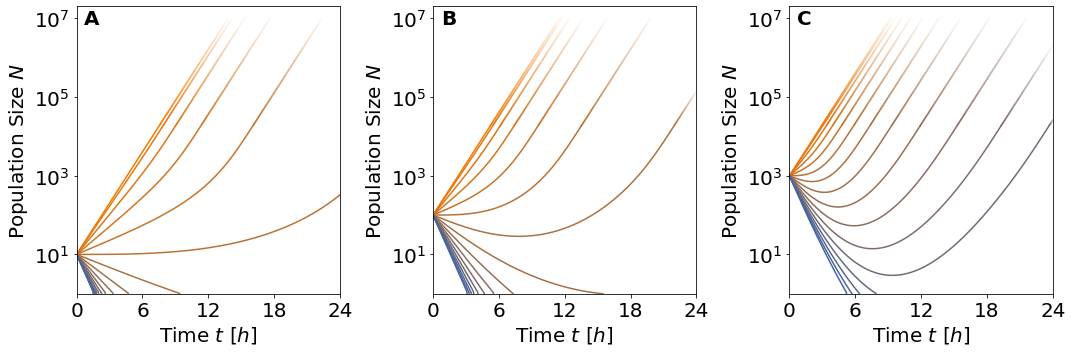

In [16]:
fig,ax = plt.subplots(1,3,figsize = (15,5))
abclist = trajectories0010.keys()
sorted(abclist)

for b0 in abclist:
    color = patch_color(float(b0)/3, color2 = [245,121,0], hexoutput=False)
    PlotFadingTrajectory(ax[0], trajectories0010[b0]['time'].values, trajectories0010[b0]['N'].values, color1 = color, threshold2 = 1e7)
    PlotFadingTrajectory(ax[1], trajectories0100[b0]['time'].values, trajectories0100[b0]['N'].values, color1 = color, threshold2 = 1e7)
    PlotFadingTrajectory(ax[2], trajectories1000[b0]['time'].values, trajectories1000[b0]['N'].values, color1 = color, threshold2 = 1e7)

adjust_ax_fig2_N(ax[0])
adjust_ax_fig2_N(ax[1])
adjust_ax_fig2_N(ax[2])

ax[0].annotate('A',[0.7,7e6],weight='bold',fontsize=20)
ax[1].annotate('B',[0.7,7e6],weight='bold',fontsize=20)
ax[2].annotate('C',[0.7,7e6],weight='bold',fontsize=20)

#ax[2].legend(loc='center left')

fig.tight_layout()
fig.savefig('trajectories.pdf')

NameError: name 'AddDF' is not defined

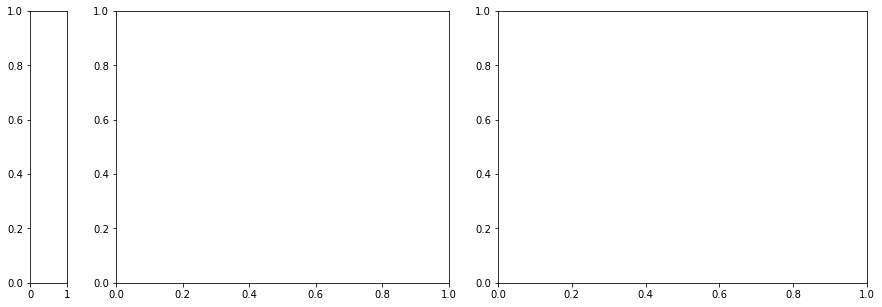

In [3]:
# classic growth measurements

def aeff(b,alpha,mu0,kappa,gamma):
    bmk = np.power(b/mu0,kappa)
    return alpha * (1 - bmk)/(1+bmk/gamma)

growth_scmic = 1.242e-2
growth_alpha = 1.049
growth_gamma = 1.320
growth_kappa = 7.049


datadir = '/home/lukas/Documents/manuscripts/antibiotics_inoculumeffect/figures/antibioticgrowth/data'

fig,ax = plt.subplots(1,3,gridspec_kw = {'width_ratios':[1,9,10]}, figsize = (15,5))

growthrate_data = None
for fn in glob.glob(datadir + '/*.growthrates'):
    cur_data        = pd.read_csv(fn, skiprows=1, names = ['abconc','growthrate','growthrate_stddev'], delim_whitespace=True)
    growthrate_data = AddDF(growthrate_data, cur_data)

trajectory_data = pd.read_csv(datadir + '/alldata_trajectories', delim_whitespace = True)
    
ax[0].set_ylim([-3.5,2.5])
ax[0].set_xlim([-1e-5,1e-5])

ax[0].errorbar(growthrate_data['abconc']/growth_scmic, growthrate_data['growthrate'], growthrate_data['growthrate_stddev'], marker = 'o',ls = '')
ax[0].plot(np.array([-1e-5,1e-5]), aeff(np.array([0,0]) * growth_scmic, growth_alpha, growth_scmic, growth_kappa, growth_gamma))

ax[1].set_xscale('log')
ax[1].set_xlim([.035,65])
ax[1].set_ylim([-3.5,2.5])

ax[1].errorbar(growthrate_data['abconc']/growth_scmic, growthrate_data['growthrate'], growthrate_data['growthrate_stddev'], marker = 'o',ls = '')
ax[1].plot(abconc, aeff(abconc * growth_scmic, growth_alpha, growth_scmic, growth_kappa, growth_gamma))


ax[0].get_shared_x_axes().join(ax[0], ax[1])


avg_traj = {}
traj_pairs = [(6,15),(20,28),(35,43),(37,45),(39,47)]
for idx1,idx2 in traj_pairs:
    label = trajectory_data.columns[idx1]
    avg_traj[trajectory_data.columns[idx1]] = np.sqrt(trajectory_data[trajectory_data.columns[idx1]].values * trajectory_data[trajectory_data.columns[idx2]].values)

    ax[2].plot(trajectory_data['#'], avg_traj[label], label = r'${:.2f}~\mu_0$'.format(float(label)/growth_scmic),marker = 'o')
ax[2].set_yscale('log')
ax[2].set_ylim([8e4,2e6])
ax[2].set_xlim([-3,63])
ax[2].legend()

